# 7. Advanced Calculation and Stistical Methods

## Regridding

Different datasets usually have different time and grid resolutions. Sometimes we need to use different datasets with the same resolution, so we need to regrid the `A` grid onto the `B` grid resolution. The simplest way to do this with xarray is using `xr.interp`. The default interpolation method of the `xr.interp` function is linear interpolation.

**Example 1:** The horizontal resolution of GPCP rainfall data is 2.5˚, and the horizontal resolution of OLR is 1˚. Now we will regrid the OLR data to the GPCP resolution.


In [1]:
import xarray as xr
lats = -20
latn =  30
lon1 =  79 
lon2 = 161

pcp_ds = xr.open_dataset('data/gpcp_precip_1979-2019.pentad.nc') 
pcp = pcp_ds.sel(lat=slice(latn,lats), lon=slice(lon1,lon2)).data
olr_ds = xr.open_dataset('data/olr.nc')
olr = olr_ds.sel(lat=slice(lats,latn), lon=slice(lon1,lon2)).olr

olr_rmp = olr.interp(lon=pcp.lon, lat=pcp.lat)   # Specify the target grid info to the `interp` method. 
olr_rmp

<xarray.DataArray 'olr' (time: 8760, lat: 20, lon: 32)> Size: 22MB
array([[[210.37125, 199.29874, 197.44077, ..., 268.05853, 268.25916,
         266.9823 ],
        [204.61313, 213.93433, 230.92719, ..., 284.24072, 282.60632,
         278.35385],
        [236.69272, 247.62692, 259.35587, ..., 294.86554, 292.45862,
         292.01804],
        ...,
        [297.27472, 302.5027 , 305.18634, ..., 193.11395, 206.42505,
         197.59212],
        [291.31464, 291.11176, 298.43726, ..., 155.4393 , 146.58469,
         162.1478 ],
        [286.89136, 290.6887 , 291.20618, ..., 171.58977, 183.45123,
         195.39035]],

       [[259.8478 , 225.8486 , 211.98647, ..., 269.50348, 269.39746,
         272.64   ],
        [276.39136, 272.1738 , 268.95856, ..., 291.94778, 289.79297,
         284.37097],
        [260.77368, 265.89886, 275.41898, ..., 301.7583 , 299.66028,
         292.9348 ],
...
        [289.9028 , 281.8377 , 285.37466, ..., 169.81645, 173.29109,
         213.98285],
        [286.0285 , 282.36426, 284.31454, ..., 111.96492, 154.03249,
         224.03793],
        [290.05353, 295.02466, 291.87067, ..., 125.69296, 153.77583,
         191.87067]],

       [[240.00652, 211.87251, 198.56546, ..., 264.23984, 258.3333 ,
         255.25803],
        [224.23218, 243.02698, 246.38681, ..., 279.6334 , 274.43097,
         277.21472],
        [234.04726, 253.98969, 263.0449 , ..., 289.64203, 291.71185,
         293.91864],
        ...,
        [286.8454 , 287.29822, 284.08643, ..., 165.07278, 165.68568,
         180.77968],
        [291.43097, 289.64923, 295.36426, ..., 178.16243, 158.17258,
         182.52911],
        [294.91678, 297.96875, 296.73392, ..., 174.35318, 157.13422,
         152.69089]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 128B 81.25 83.75 86.25 88.75 ... 153.8 156.2 158.8
  * lat      (lat) float32 80B 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

However, sometimes linear interpolation is not the best way to regrid. For example, rainfall need to stay mass conservation after regridding, therefore **conservative** regridding is required. Here we introduce `xesmf` library to do this. 

**Example 1:** Regrid the GPCP data to the OLR resolution.

In [2]:
import xesmf as xe

# Set the grid information 
grid_olr  = xr.Dataset({'lat':olr.lat, 'lon':olr.lon}) 
grid_gpcp = xr.Dataset({'lat':pcp.lat, 'lon':pcp.lon}) 
# ds_in: the input grid info; 
# ds_out: the output grid info
regridder = xe.Regridder(ds_in=grid_gpcp , ds_out=grid_olr, method="conservative_normed")
pcp_rg = regridder(pcp,keep_attrs=True)

KeyError: 'Author'

## Change Coordinate Resolution

時間和空間的網格解析度可以用採用 `xarray.DataArray.coarsen` 更改。

**Example 3:** 將每日OLR轉換成侯(pentad)平均資料，意即將時間解析度調整為5天一次。

In [3]:
olr_noleap = olr.sel(time=~((olr.time.dt.month == 2) & (olr.time.dt.day == 29)))
olr_ptd = (olr_noleap.coarsen(time=5,
                              coord_func={"time": "min"})  
                     .mean())
olr_ptd

<xarray.DataArray 'olr' (time: 1752, lat: 50, lon: 82)>
array([[[284.27383, 285.73615, 288.25266, ..., 231.88799, 241.6569 ,
         249.84024],
        [286.65228, 288.0508 , 288.27435, ..., 215.95383, 230.82944,
         246.1481 ],
        [290.7838 , 290.2586 , 287.82904, ..., 198.27681, 214.98921,
         225.9622 ],
        ...,
        [247.29614, 246.06245, 247.9498 , ..., 279.0298 , 277.99088,
         276.57684],
        [244.55948, 242.81021, 239.57669, ..., 273.2099 , 271.63373,
         270.99365],
        [236.1903 , 229.96805, 221.43008, ..., 266.5147 , 266.81476,
         266.7093 ]],

       [[257.097  , 249.0689 , 260.7727 , ..., 251.24785, 258.4394 ,
         267.57504],
        [265.49664, 263.9062 , 270.4431 , ..., 237.29636, 248.2174 ,
         250.10226],
        [261.7508 , 266.22888, 276.74783, ..., 222.4416 , 235.64157,
         227.53247],
...
        [246.52588, 246.06046, 249.06099, ..., 256.54034, 259.21564,
         260.40427],
        [244.2377 , 247.02632, 246.57185, ..., 258.28464, 255.90445,
         257.71054],
        [237.54703, 235.23251, 224.96394, ..., 255.28891, 253.66435,
         255.53586]],

       [[286.864  , 287.83688, 290.30945, ..., 194.66502, 212.79057,
         210.36748],
        [288.31   , 288.92453, 290.12537, ..., 204.64694, 225.9674 ,
         223.37724],
        [284.80383, 288.20563, 289.7766 , ..., 215.14029, 236.13554,
         232.43852],
        ...,
        [236.44717, 236.95544, 234.64787, ..., 268.50082, 268.91937,
         267.25333],
        [235.04623, 231.87952, 229.08992, ..., 267.69647, 267.49542,
         266.0851 ],
        [233.44182, 225.93411, 211.10928, ..., 268.23108, 265.9177 ,
         264.84662]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-06 ... 2021-12-27
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 26.5 27.5 28.5 29.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

也就是在時間的維度上，5天為一個單位平均。 `coord_func` 預設為 `mean`，也就是重新取樣後的座標 (時間) 軸會選擇5天平均後的時間軸 (如1998-01-03, 1998-01-08, 1998-01-13, ...)，其他選項可選 `min` 設定為最小值 (一侯的開始日) 或 `max` 最大值 (一侯的結束日)。

**Note:** 雖然`xarray.DataArray.resample`看似也有同樣功能，但根據API reference，
> The resampled dimension must be a datetime-like coordinate.

根據以上範例，就是 `olr_ptd = olr_noleap.resample(time='5D')` ，然而`datetime` 物件無法選擇日曆格式，也就是在計算五天平均時，不論原始資料 `olr_noleap` 有沒有2/29，這個方法都會納入2/29 (延伸閱讀：[StackOverflow 的問答](https://stackoverflow.com/questions/64476727/can-we-assign-the-calendar-of-pandas-datetimeindex-as-noleap-or-can-datetime))。

```{admonition} Exercise
:class: seealso
請利用coarsen改變空間的解析度 (i.e. 將1˚解析度的OLR資料regrid成2˚解析度)。
```

## 滑動平均 (running mean)

可利用 `xarray.DataArray.rolling`，連續選擇3個單位，再進行平均。

In [4]:
olr_3p_runave = (olr_ptd.rolling(time=3,        # 選擇幾個時間單位
                                 center=False)
                        .mean())
olr_3p_runave

<xarray.DataArray 'olr' (time: 1752, lat: 50, lon: 82)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [258.01865, 258.54132, 260.59457, ..., 265.62262, 266.46997,
         267.72852],
        [254.52092, 255.43341, 253.74515, ..., 262.07703, 262.12787,
         264.36252],
        [249.05486, 243.50095, 230.53357, ..., 257.8312 , 259.1329 ,
         259.55786]],

       [[285.45612, 286.57214, 287.6652 , ..., 247.677  , 257.28473,
         259.3609 ],
        [288.13184, 288.3128 , 289.0145 , ..., 255.27068, 264.8253 ,
         264.77902],
        [288.0848 , 289.45697, 289.93057, ..., 261.4938 , 269.81818,
         268.2691 ],
        ...,
        [248.90976, 249.10083, 250.33572, ..., 262.9018 , 263.4146 ,
         263.58185],
        [247.00436, 247.02068, 245.05011, ..., 261.76514, 261.24374,
         261.8905 ],
        [243.24814, 237.90851, 224.16135, ..., 258.3669 , 257.77066,
         257.97882]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-06 ... 2021-12-27
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 26.5 27.5 28.5 29.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

由於頭尾會有缺失值NaN，可加上`dropna()`移除之。

## 相關係數地圖 (correlation map)

給定兩個DataArray，我們就可以計算兩者之間沿著特定座標軸 (e.g. 沿著時間軸的) 的相關係數。

**Example 4:** 計算NDJ [Oceanic Niño Index (ONI)](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php) 和十二月降雨的相關係數地圖。

Step 1: 得到GPCP十二月平均資料 (先所有選12月資料，再用`groupby`)

In [5]:
pcp_dec = (pcp.sel(time=pcp.time.dt.month.isin([12]))
              .groupby('time.year')
              .mean("time"))
pcp_dec

<xarray.DataArray 'data' (year: 41, lat: 20, lon: 32)>
array([[[1.0133333e+00, 9.1833329e-01, 7.9833335e-01, ...,
         3.6333334e+00, 2.7116668e+00, 2.5383332e+00],
        [2.0333333e-01, 4.2833331e-01, 2.5000000e-01, ...,
         2.4483333e+00, 2.3216665e+00, 1.7766665e+00],
        [5.4999996e-02, 1.3666667e-01, 1.5833335e-01, ...,
         2.2033336e+00, 1.8683332e+00, 1.2850000e+00],
        ...,
        [1.1466666e+00, 1.4949999e+00, 1.8333334e+00, ...,
         3.6483333e+00, 4.2433333e+00, 2.9916668e+00],
        [7.1833330e-01, 1.3866667e+00, 1.4466667e+00, ...,
         4.0750003e+00, 3.2466669e+00, 2.8599999e+00],
        [3.9666665e-01, 8.2333332e-01, 1.1883334e+00, ...,
         2.9016666e+00, 2.7083333e+00, 1.7416667e+00]],

       [[4.6500000e-01, 2.8333333e-01, 3.4333333e-01, ...,
         3.8716667e+00, 3.8799999e+00, 3.4633334e+00],
        [6.0833335e-01, 1.7000000e-01, 1.4666666e-01, ...,
         3.9750001e+00, 3.6300001e+00, 3.1483333e+00],
        [1.2800001e+00, 3.2166669e-01, 1.2000000e-01, ...,
         2.4466667e+00, 2.1550000e+00, 1.1616668e+00],
...
        [7.9235015e+00, 7.0794005e+00, 5.7172127e+00, ...,
         9.7668800e+00, 1.0939357e+01, 1.0846936e+01],
        [9.5492640e+00, 7.4848499e+00, 3.3095343e+00, ...,
         1.2228072e+01, 1.2528176e+01, 1.1302447e+01],
        [7.2531962e+00, 5.3915715e+00, 2.0546637e+00, ...,
         1.0486613e+01, 1.3482674e+01, 1.1387763e+01]],

       [[2.0096309e+00, 1.1509016e+00, 4.8980752e-01, ...,
         2.0202532e+00, 2.7056713e+00, 2.6676538e+00],
        [1.2896461e+00, 1.1470729e+00, 2.6983759e-01, ...,
         1.3239046e+00, 1.6525987e+00, 1.6284056e+00],
        [8.9463830e-01, 3.9747801e-01, 1.5476857e-01, ...,
         1.1533502e+00, 1.1403440e+00, 9.9328095e-01],
        ...,
        [1.2956619e+00, 6.6536534e-01, 5.8920252e-01, ...,
         4.1320643e+00, 4.3791137e+00, 4.1250496e+00],
        [1.7519032e+00, 1.2151116e+00, 9.6764684e-01, ...,
         5.1612849e+00, 5.1797566e+00, 2.8651981e+00],
        [3.1523111e+00, 2.0467207e+00, 1.0773114e+00, ...,
         3.6295269e+00, 4.3244128e+00, 2.4604805e+00]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 81.25 83.75 86.25 88.75 ... 151.2 153.8 156.2 158.8
  * lat      (lat) float32 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018 2019
Attributes:
    long_name:  GPCP pentad precipitation (mm/day)
    units:      mm/day

Step 2: 製造NDJ ONI index矩陣。

In [6]:
oni_ndj = xr.DataArray( 
                       data=[0.6, 0.0, -0.1, 2.2, -0.9, -1.1, -0.4, 1.2, 1.1, -1.8, -0.1, 0.4, 
                             1.5, -0.1, 0.1, 1.1, -1.0, -0.5, 2.4, -1.6, -1.7, -0.7, 
                             -0.3, 1.1, 0.4, 0.7, -0.8, 0.9, -1.6, -0.7, 1.6, -1.6, 
                             -1.0, -0.2, -0.3, 0.7, 2.6, -0.6, -1.0, 0.8, 0.5],
                       dims='year',
                       coords=dict(year=pcp_dec.year)
                       )
oni_ndj

<xarray.DataArray (year: 41)>
array([ 0.6,  0. , -0.1,  2.2, -0.9, -1.1, -0.4,  1.2,  1.1, -1.8, -0.1,
        0.4,  1.5, -0.1,  0.1,  1.1, -1. , -0.5,  2.4, -1.6, -1.7, -0.7,
       -0.3,  1.1,  0.4,  0.7, -0.8,  0.9, -1.6, -0.7,  1.6, -1.6, -1. ,
       -0.2, -0.3,  0.7,  2.6, -0.6, -1. ,  0.8,  0.5])
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018 2019

Step 3: 用`xr.corr`計算相關係數。

In [7]:
corr = xr.corr(pcp_dec,oni_ndj,dim='year')
corr

<xarray.DataArray (lat: 20, lon: 32)>
array([[ 3.62929452e-01,  3.42366935e-01,  1.36141385e-01,
         2.86181885e-01,  1.81635007e-01,  1.49191933e-01,
         2.91984747e-01,  4.77790062e-01,  4.72934980e-01,
         2.59950214e-01,  3.45925729e-01,  3.45836394e-01,
         2.41839289e-01,  3.26920710e-01,  3.12002374e-01,
         2.78955901e-01,  2.83943380e-01,  3.95803450e-01,
         4.20742051e-01,  4.71375054e-01,  5.46175408e-01,
         4.34086465e-01,  3.36992606e-01,  2.34458518e-01,
         3.30061209e-01,  2.83089068e-01,  6.62670164e-02,
        -6.41038383e-02, -8.02357126e-02, -1.32435603e-01,
        -6.14116577e-02, -3.57627814e-01],
       [ 3.83909987e-01,  3.03894582e-01,  2.37785616e-01,
         2.14941992e-01,  1.29919746e-01,  9.02064326e-02,
         1.65142443e-01,  2.02511225e-01,  2.68816770e-01,
         1.56273306e-01,  2.46169180e-01,  3.13843048e-01,
         3.71282366e-01,  3.76425080e-01,  3.56976452e-01,
         3.31840158e-01,  1.84695348e-01,  4.19843103e-01,
         4.71277802e-01,  4.27318315e-01,  3.51365941e-01,
         2.37002913e-01,  2.34139483e-01,  2.04142657e-01,
         1.27191143e-01, -7.16084696e-02, -1.17030947e-01,
...
        -1.63141768e-01,  2.02073967e-02,  8.64961743e-02,
        -6.46165929e-02, -1.30967877e-01, -1.11179142e-01,
        -2.19488532e-01, -3.89394397e-01, -5.41138832e-01,
        -5.55411086e-01, -4.62892783e-01, -3.87886292e-01,
        -2.86447708e-01, -1.87858258e-01, -4.88526454e-02,
        -6.03390847e-02, -5.92937090e-02, -1.09022023e-02,
        -1.62940949e-01, -1.06521328e-01, -1.63654736e-01,
        -2.66138362e-01, -3.63495740e-01, -3.56191141e-01,
        -3.43018577e-01, -4.02329768e-01],
       [ 2.18229674e-01,  1.50764053e-01,  4.34983952e-02,
        -2.31485281e-02, -1.24680834e-01, -2.82829671e-01,
        -2.27022137e-01, -1.80625263e-01, -6.68313177e-02,
        -1.22718872e-01, -7.70160205e-02, -1.92838402e-01,
        -2.63437000e-01, -4.77678670e-01, -6.13706400e-01,
        -5.25689479e-01, -3.34162312e-01, -3.46265743e-01,
        -2.73299118e-01, -3.36175549e-01, -1.75612517e-01,
        -7.18667328e-02, -2.45879382e-02,  2.50092725e-03,
        -1.46619847e-01, -7.41479082e-02, -3.23609599e-02,
        -1.90437806e-01, -2.59385838e-01, -3.08636754e-01,
        -2.93624430e-01, -3.09437350e-01]])
Coordinates:
  * lon      (lon) float32 81.25 83.75 86.25 88.75 ... 151.2 153.8 156.2 158.8
  * lat      (lat) float32 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75

Step 4: 將計算好的結果畫出來看看。

/Users/waynetsai/micromamba/envs/p3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


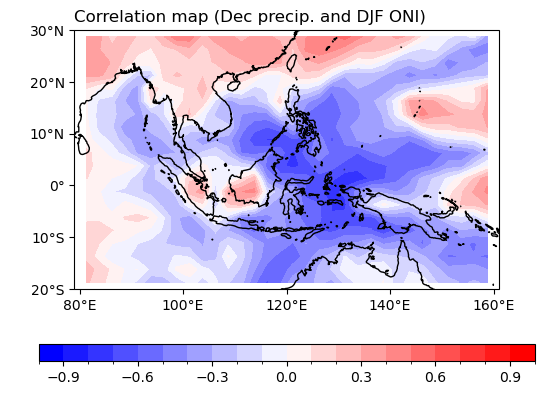

In [8]:
import numpy as np
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 100

proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})                  

clevs = np.arange(170,350,20)

# 繪圖
plt.title("Correlation map (Dec precip. and DJF ONI)", loc='left')    # 設定圖片標題，並且置於圖的左側。
olrPlot = (corr.plot.contourf("lon", "lat",  
                              ax=ax,       
                              levels=np.arange(-1,1.1,0.1), 
                              cmap='bwr',  
                              add_colorbar=True, 
                              extend='neither', 
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                              )
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-20,40,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()                              
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()

## `where`條件控制

`where`是一個很好用的方法，可以針對資料設定條件進行篩選和過濾。我們直接看以下例子：

**Example 4:** 繪製2021年12月平均之Mean Sea Level Pressure，但海拔3000公尺以上的區域不畫。

Step 1: 讀MSLP、地形資料。




In [9]:
lats=0
latn=60

topo_ds = xr.open_dataset('data/etopo5.nc')
mslp_ds = xr.open_dataset('data/mslp.2021.nc')
topo = topo_ds.sel(Y=slice(lats,latn),
                   X=slice(lon1,lon2)).bath
mslp = mslp_ds.sel(time=slice('2021-12-01','2021-12-31'),
                   lat=slice(latn,lats),
                   lon=slice(lon1,lon2)).mslp
mslp = mslp/100.

`where`的原理是搜尋兩者相對應的網格是否滿足給定的控制條件 （以這個範例來說是搜尋topo >= 3000的網格點），但兩者網格解析度不同時，沒有辦法比較。因此必須先進行網格內插，讓`topo`和`mslp`的解析度相同。

In [10]:
topo_rmp = topo.interp(X=mslp.lon, Y=mslp.lat)

接著用`where`設定條件：

In [11]:
mslp_mask = mslp.where(topo_rmp<=3000)
mslp_mask

<xarray.DataArray 'mslp' (time: 31, lat: 25, lon: 33)>
array([[[1013.425, 1015.375, 1017.25 , ..., 1015.8  , 1015.5  ,
         1015.45 ],
        [1019.35 , 1020.625, 1021.65 , ..., 1009.975, 1012.825,
         1015.25 ],
        [1023.575, 1024.4  , 1025.175, ..., 1008.025, 1013.475,
         1017.35 ],
        ...,
        [1010.3  , 1009.675, 1008.85 , ..., 1006.8  , 1007.1  ,
         1007.05 ],
        [1010.15 , 1009.875, 1009.05 , ..., 1006.775, 1007.25 ,
         1007.125],
        [1010.075, 1009.9  , 1009.175, ..., 1007.15 , 1007.35 ,
         1007.275]],

       [[1003.85 , 1006.025, 1008.05 , ...,  983.225,  983.4  ,
          984.375],
        [1010.625, 1012.975, 1015.025, ...,  974.25 ,  978.325,
          981.95 ],
        [1015.5  , 1017.675, 1019.55 , ...,  976.95 ,  981.475,
          985.325],
...
        [1011.025, 1010.875, 1010.8  , ..., 1008.775, 1008.8  ,
         1008.825],
        [1010.625, 1010.525, 1010.65 , ..., 1009.075, 1008.9  ,
         1008.65 ],
        [1011.025, 1010.85 , 1010.825, ..., 1008.475, 1008.325,
         1008.75 ]],

       [[1024.175, 1025.275, 1026.675, ..., 1019.775, 1019.725,
         1019.45 ],
        [1029.125, 1029.8  , 1030.6  , ..., 1006.275, 1007.75 ,
         1010.   ],
        [1034.4  , 1034.875, 1035.45 , ...,  995.475,  997.3  ,
         1000.925],
        ...,
        [1011.825, 1011.275, 1010.975, ..., 1009.225, 1009.4  ,
         1009.475],
        [1011.55 , 1011.   , 1010.475, ..., 1008.975, 1009.125,
         1008.975],
        [1011.575, 1011.275, 1010.925, ..., 1008.9  , 1009.2  ,
         1009.025]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 60.0 57.5 55.0 52.5 50.0 ... 10.0 7.5 5.0 2.5 0.0
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 ... 152.5 155.0 157.5 160.0
  * time     (time) datetime64[ns] 2021-12-01 2021-12-02 ... 2021-12-31
    X        (lon) float32 80.0 82.5 85.0 87.5 90.0 ... 152.5 155.0 157.5 160.0
    Y        (lat) float32 60.0 57.5 55.0 52.5 50.0 ... 10.0 7.5 5.0 2.5 0.0

我們設定的條件就是`topo<=3000`，不滿足的會直接被設定為缺失值。也可以在`where`的引數`other`中，設定當不滿足條件時要代入的值。

/Users/waynetsai/micromamba/envs/p3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


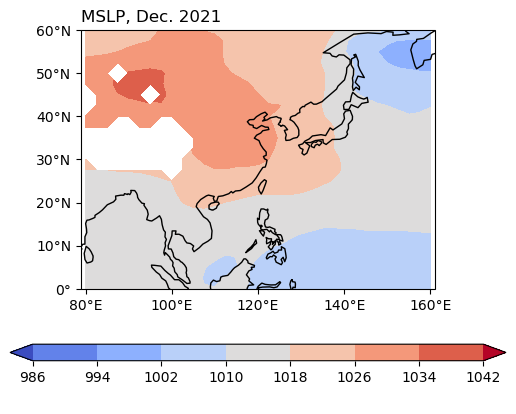

In [12]:
proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})     

# 繪圖
plt.title("MSLP, Dec. 2021", loc='left')    # 設定圖片標題，並且置於圖的左側。
olrPlot = (mslp_mask.mean(axis=0)
                    .plot.contourf("lon", "lat",  
                                   ax=ax,       
                                   levels=np.arange(986,1048,8), 
                                   cmap='coolwarm',  
                                   add_colorbar=True, 
                                   extend='both', 
                                   cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                                   )
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(0,70,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()                      
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()

## 計算相對渦度 (vorticity)、散度 (divergence)

以上的計算都只是一些基本的統計，利用xarray的函數就可以辦到。但如果想要計算一些氣象的函數應該怎麼辦呢？我們可以使用MetPy，目前MetPy對xarray有完整的支援，可以直接將DataArray讀入MetPy的函數中。接下來我們以計算相對渦度為例，渦度和散度是氣象上常用來衡量風的旋轉量和輻合散的方法，[metpy.calc.vorticity](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.vorticity.html) 可以用來計算渦度。

**Example 5:** 計算2017年12月平均之850-hPa 相對渦度。

Step 1: 讀風場資料、選擇時空範圍。

In [13]:
latn = 30 
lats = -20

uds = xr.open_dataset('data/ncep_r2_uv850/u850.2017.nc')
vds = xr.open_dataset('data/ncep_r2_uv850/v850.2017.nc')
u = uds.sel(time=slice('2017-12-01','2017-12-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).uwnd
v = vds.sel(time=slice('2017-12-01','2017-12-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).vwnd

Step 2: 利用MetPy計算渦度。

在計算前，應檢查u, v是不是有單位 m/s，如果沒有的話，必須先利用MetPy加上單位才能進行渦度計算。

In [14]:
import metpy.calc as mpcalc
from metpy.units import units
vor = mpcalc.vorticity(u*units('m/s'), v*units('m/s'))
vorm = vor.mean(axis=0)
vorm

<xarray.DataArray (lat: 21, lon: 33)>
<Quantity([[ 2.27227035e-06 -6.35822645e-06 -1.46749070e-05 -2.08053115e-05
  -2.30204190e-05 -2.14179636e-05 -1.73882539e-05 -1.29046760e-05
  -9.84929500e-06 -9.54206099e-06 -1.12507049e-05 -1.23807539e-05
  -1.01248504e-05 -4.97617877e-06 -9.28601335e-07 -2.13257232e-06
  -8.04519296e-06 -1.36745794e-05 -1.37081362e-05 -8.49913312e-06
  -2.77764758e-06 -1.18851542e-06 -3.59719131e-06 -6.00788240e-06
  -5.68558831e-06 -3.57765352e-06 -2.98596786e-06 -5.61280440e-06
  -9.78352706e-06 -1.28709753e-05 -1.36409031e-05 -1.30405734e-05
  -1.21284570e-05]
 [ 1.59641488e-06  1.27951490e-07 -2.96147587e-06 -6.09627077e-06
  -7.14075885e-06 -6.30349598e-06 -5.16875042e-06 -4.56615673e-06
  -4.01070010e-06 -3.29133037e-06 -3.14996178e-06 -4.03313727e-06
  -5.06772766e-06 -5.30085544e-06 -5.33611754e-06 -7.06711890e-06
  -1.08910896e-05 -1.43131536e-05 -1.42338578e-05 -1.03047389e-05
  -5.71612173e-06 -3.96175474e-06 -5.53658936e-06 -7.88921794e-06
  -8.64479278e-06 -8.03751306e-06 -8.04710263e-06 -9.82336098e-06
  -1.24495122e-05 -1.41660453e-05 -1.44190610e-05 -1.42504704e-05
  -1.44654921e-05]
 [-2.25853323e-06  1.13172266e-06  2.50715062e-06  3.24109081e-06
   4.54796451e-06  5.22032636e-06  3.42384104e-06  8.61968466e-08
...
  -8.52059086e-06 -1.10716107e-05 -1.19881288e-05 -1.13950856e-05
  -9.98141214e-06]
 [ 3.40814844e-07 -1.87193747e-06 -2.55199434e-06 -1.83217317e-06
  -7.07930811e-07 -2.45485863e-07 -7.17219789e-07 -1.21135839e-06
  -6.77305687e-07  1.98063110e-07 -8.42058040e-07 -4.36596747e-06
  -7.21982209e-06 -6.11138032e-06 -2.24744337e-06  6.50249030e-08
  -5.85517420e-07 -8.93727851e-07  1.92617077e-06  5.34523983e-06
   4.91827661e-06  6.98802749e-07 -2.36916696e-06 -8.49899076e-07
   3.18171194e-06  5.20927594e-06  3.40469449e-06 -5.15668196e-07
  -4.15454945e-06 -6.51466556e-06 -7.57468620e-06 -7.70031620e-06
  -7.32678885e-06]
 [ 3.86059996e-06  4.83366406e-07 -1.67842807e-06 -2.14714011e-06
  -1.31075583e-06 -6.41593796e-07 -9.82999754e-07 -1.46979384e-06
  -7.01365099e-07  5.12796672e-07 -4.05116393e-07 -4.63963087e-06
  -8.87224706e-06 -8.92474419e-06 -4.83957896e-06 -1.08197146e-06
  -7.43141058e-07 -2.15767543e-06 -1.95926642e-06 -1.83126193e-07
  -9.75771821e-09 -3.08505634e-06 -6.80966442e-06 -7.53604087e-06
  -4.54671714e-06 -6.88500940e-08  3.41230334e-06  4.97175514e-06
   4.77222735e-06  3.07068630e-06  7.25767405e-07 -1.38476001e-06
  -2.89335635e-06]], '1 / second')>
Coordinates:
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 ... 152.5 155.0 157.5 160.0
  * lat      (lat) float32 30.0 27.5 25.0 22.5 20.0 ... -12.5 -15.0 -17.5 -20.0
    level    float32 850.0

以上預覽的資訊中，多了「Magnitude」和「Units」的資訊，這是因為在MetPy計算中，單位也很重要，因此除了文字格式的Unit attribute之外，DataArray還附上單位資訊，稱為「unit-aware array type」。如果將這個DataArray繼續做其他的計算，單位仍會保留下來。

有時候將unit-aware array type餵給某些函數時，程式不認得而造成錯誤，此時可以用 `.dequantify()` 的方式轉換成一般的DataArray，或稱為「unit-naive array type」。

In [15]:
vorm.metpy.dequantify()

<xarray.DataArray (lat: 21, lon: 33)>
array([[ 2.27227035e-06, -6.35822645e-06, -1.46749070e-05,
        -2.08053115e-05, -2.30204190e-05, -2.14179636e-05,
        -1.73882539e-05, -1.29046760e-05, -9.84929500e-06,
        -9.54206099e-06, -1.12507049e-05, -1.23807539e-05,
        -1.01248504e-05, -4.97617877e-06, -9.28601335e-07,
        -2.13257232e-06, -8.04519296e-06, -1.36745794e-05,
        -1.37081362e-05, -8.49913312e-06, -2.77764758e-06,
        -1.18851542e-06, -3.59719131e-06, -6.00788240e-06,
        -5.68558831e-06, -3.57765352e-06, -2.98596786e-06,
        -5.61280440e-06, -9.78352706e-06, -1.28709753e-05,
        -1.36409031e-05, -1.30405734e-05, -1.21284570e-05],
       [ 1.59641488e-06,  1.27951490e-07, -2.96147587e-06,
        -6.09627077e-06, -7.14075885e-06, -6.30349598e-06,
        -5.16875042e-06, -4.56615673e-06, -4.01070010e-06,
        -3.29133037e-06, -3.14996178e-06, -4.03313727e-06,
        -5.06772766e-06, -5.30085544e-06, -5.33611754e-06,
        -7.06711890e-06, -1.08910896e-05, -1.43131536e-05,
        -1.42338578e-05, -1.03047389e-05, -5.71612173e-06,
        -3.96175474e-06, -5.53658936e-06, -7.88921794e-06,
        -8.64479278e-06, -8.03751306e-06, -8.04710263e-06,
...
        -7.17219789e-07, -1.21135839e-06, -6.77305687e-07,
         1.98063110e-07, -8.42058040e-07, -4.36596747e-06,
        -7.21982209e-06, -6.11138032e-06, -2.24744337e-06,
         6.50249030e-08, -5.85517420e-07, -8.93727851e-07,
         1.92617077e-06,  5.34523983e-06,  4.91827661e-06,
         6.98802749e-07, -2.36916696e-06, -8.49899076e-07,
         3.18171194e-06,  5.20927594e-06,  3.40469449e-06,
        -5.15668196e-07, -4.15454945e-06, -6.51466556e-06,
        -7.57468620e-06, -7.70031620e-06, -7.32678885e-06],
       [ 3.86059996e-06,  4.83366406e-07, -1.67842807e-06,
        -2.14714011e-06, -1.31075583e-06, -6.41593796e-07,
        -9.82999754e-07, -1.46979384e-06, -7.01365099e-07,
         5.12796672e-07, -4.05116393e-07, -4.63963087e-06,
        -8.87224706e-06, -8.92474419e-06, -4.83957896e-06,
        -1.08197146e-06, -7.43141058e-07, -2.15767543e-06,
        -1.95926642e-06, -1.83126193e-07, -9.75771821e-09,
        -3.08505634e-06, -6.80966442e-06, -7.53604087e-06,
        -4.54671714e-06, -6.88500940e-08,  3.41230334e-06,
         4.97175514e-06,  4.77222735e-06,  3.07068630e-06,
         7.25767405e-07, -1.38476001e-06, -2.89335635e-06]])
Coordinates:
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 ... 152.5 155.0 157.5 160.0
  * lat      (lat) float32 30.0 27.5 25.0 22.5 20.0 ... -12.5 -15.0 -17.5 -20.0
    level    float32 850.0
Attributes:
    units:    1 / second

單位就會被轉換為文字格式的attribute。

Step 3: 繪圖。

/Users/waynetsai/micromamba/envs/p3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


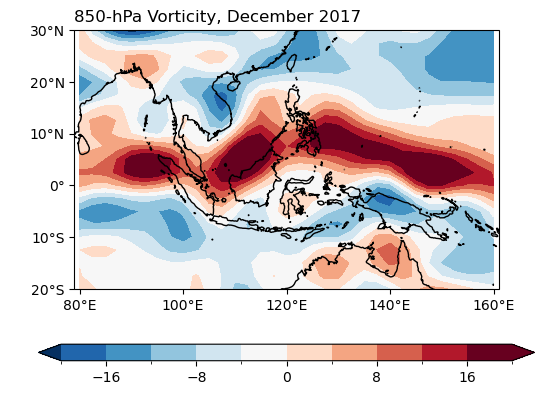

In [16]:
import cmaps

proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj}) 

vorm = vorm * 10e5
vorPlot = (vorm.plot.contourf("lon", "lat",  
                              ax=ax,       
                              levels=np.arange(-20,24,4), 
                              cmap=cmaps.CBR_coldhot,  
                              add_colorbar=True, 
                              extend='both', 
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                              )
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-20,40,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()
                         
ax.set_title(' ')
ax.set_title('850-hPa Vorticity, December 2017', loc='left')
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()

```{admonition} Exercise
:class: tip
同Example 5，但計算散度 [metpy.calc.divergence](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.divergence.html)。
```

## 計算經驗正交函數 (EOF)

使用`eofs`套件，範例請見[官方網站](https://ajdawson.github.io/eofs/latest/examples/xarray_examples_index.html)。

In [17]:
from eofs.xarray import Eof

用法是
```
solver = Eof(data_array)
```
然後`solver`會有幾個methods: 
- `solver.eofs()`: 計算EOF的主模態。若給定`neofs`引數，可以得到對應的模態數量。
- `solver.pcs()`: 計算rincipal component的時間序列。
- `solver.varianceFraction()`: 計算各個模態變異度佔全部的比例，也就是各個模態能夠解釋原始DataArray的程度之比例。
- `solver.reconstructedField()`: 利用EOF模態和時間序列重建得到的變數場。
- `solver.projectField()`: 將變數投影到EOF主模態上。